# Besoin 1


# Préparation des données

In [4]:
import pandas as pd
# chargement des données
df = pd.read_csv("data_clean.csv", delimiter=';')
colonnes_utiles = ['LAT', 'LON', 'SOG', 'COG','Heading'] # selection des colonnes pertinentes pour clustering
df = df[colonnes_utiles].dropna() #supprime les lignes ou mes col pertinentes ont NA
df = df.reset_index(drop=True)

#normalise les données car elles ne son pas a la meme echelle
# LON LAT -180 et +180 heading 0 à 360 SOG 0 à 30+
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Determination de K avec silhouette

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import  matplotlib.pyplot as plt

silhouette_scores = []
inertias = []
range_n_clusters = range(2,6)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters = k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append((k,score))
    print(f"nombre de cluster: {k} - silhouette score : {score:.4f}")
# Trouver le meilleur k
best_k, best_score = max(silhouette_scores, key=lambda x: x[1])
print(f"\n>> Meilleur nombre de clusters :", {best_k})
print(f">> Score de silhouette correspondant : {best_score:.4f}")


nombre de cluster: 2 - silhouette score : 0.4009
nombre de cluster: 3 - silhouette score : 0.4928
nombre de cluster: 4 - silhouette score : 0.4488
nombre de cluster: 5 - silhouette score : 0.4820

>> Meilleur nombre de clusters : {3}
>> Score de silhouette correspondant : 0.4928


# Reduction des variables en 2 composantes principales

In [6]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#Reduction des 5 variabes en 2 composantes principales
pca= PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Clustering avec KMeans

/tmp/ipython-input-7-3597786808.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', best_k)


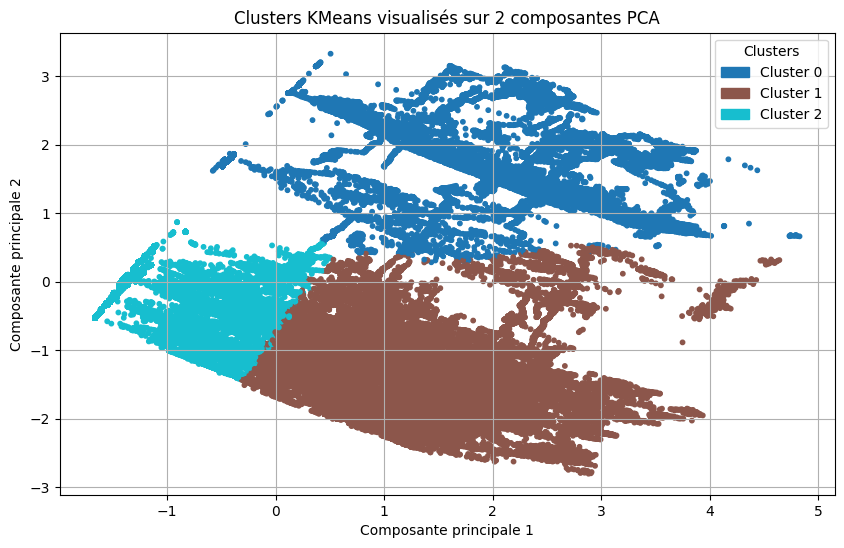

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from matplotlib import cm                 # pour récupérer le colormap
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# --- Figure unique ---
fig, ax = plt.subplots(figsize=(10, 6))
# Nuage de points (PCA 2 D)
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=labels_kmeans,
    cmap='tab10',
    s=10
)
ax.set_title("Clusters KMeans visualisés sur 2 composantes PCA")
ax.set_xlabel("Composante principale 1")
ax.set_ylabel("Composante principale 2")
ax.grid(True)

# Légende
cmap = cm.get_cmap('tab10', best_k)
handles = [mpatches.Patch(color=cmap(i), label=f'Cluster {i}') for i in range(best_k)]
ax.legend(handles=handles, title="Clusters", loc="best")
plt.show()


# Clustering avec DBSCAN

In [1]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# Clustering
dbscan = DBSCAN(eps=0.7, min_samples=10)
labels = dbscan.fit_predict(X_scaled)
df['cluster_DBSCAN'] = labels
# Info clusters
labels_set = set(labels)
if -1 in labels_set:
    labels_set.remove(-1)
n_clusters = len(labels_set)
n_bruit = list(labels).count(-1)
print(f"Nombre de clusters trouvés hors bruit:", n_clusters)
print("Nombre de points considérés comme bruit:", n_bruit)

# Visualisation avec légende sur le même graphe
plt.figure(figsize=(10,6))
unique_labels = sorted(set(labels))
cmap = plt.cm.get_cmap('viridis', len(unique_labels))
handles = []

for idx, label in enumerate(unique_labels):
    mask = (labels == label)
    color = 'black' if label == -1 else cmap(idx)
    nom = "Bruit" if label == -1 else f"Cluster {label}"

    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=10, color=color, label=nom)
    handles.append(mpatches.Patch(color=color, label=nom))

plt.title("Clusters DBSCAN visualisés sur 2 composantes PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.legend(handles=handles, title="Clusters", loc="best")
plt.show()

NameError: name 'X_scaled' is not defined

# Evaluation et caracterisation de KMeans

In [2]:
# evaluation des cluster
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Évaluation du clustering KMeans
print("\nÉvaluation du clustering KMeans :")
print(f"Silhouette Score : {silhouette_score(X_scaled, labels_kmeans):.4f}")
print(f"Calinski-Harabasz Index : {calinski_harabasz_score(X_scaled, labels_kmeans):.2f}")
print(f"Davies-Bouldin Index : {davies_bouldin_score(X_scaled, labels_kmeans):.4f}")

# Caracteristiques des cluster
df['cluster_kmeans'] = labels_kmeans # Ajout du label de cluster KMeans au DataFrame
print("\n==== Analyse statistique des clusters KMeans ====") # Statistiques descriptives par cluster
kmeans_stats = df.groupby('cluster_kmeans')[['SOG', 'COG', 'Heading', 'LAT', 'LON']].agg(['mean', 'std', 'min', 'max'])
print(kmeans_stats)



Évaluation du clustering KMeans :


NameError: name 'silhouette_score' is not defined

# Caracterisation en fct de SOG, COG, Heading

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5)) # Vitesse (SOG) par cluster
sns.boxplot(x='cluster_kmeans', y='SOG', data=df)
plt.title("Distribution de la vitesse (SOG) par cluster KMeans")
plt.grid()
plt.show()

plt.figure(figsize=(8,5)) # Cap (COG) par cluster
sns.boxplot(x='cluster_kmeans', y='COG', data=df)
plt.title("Distribution du cap (COG) par cluster KMeans")
plt.grid()
plt.show()

plt.figure(figsize=(8,5)) # Direction (Heading) par cluster
sns.boxplot(x='cluster_kmeans', y='Heading', data=df)
plt.title("Distribution de la direction (Heading) par cluster KMeans")
plt.grid()
plt.show()


# Evaluation de DBSCAN

In [ ]:
if n_clusters >= 2:
    mask = labels != -1
    print("\nÉvaluation du clustering DBSCAN :")
    print(f"Silhouette Score : {silhouette_score(X_scaled[mask], labels[mask]):.4f}")
    print(f"Calinski-Harabasz Index : {calinski_harabasz_score(X_scaled[mask], labels[mask]):.2f}")
    print(f"Davies-Bouldin Index : {davies_bouldin_score(X_scaled[mask], labels[mask]):.4f}")
else:
    print("\nÉvaluation du clustering DBSCAN : non applicable (moins de 2 clusters)")


# Création de la carte pour KMeans

In [ ]:
import plotly.express as px
px.set_mapbox_access_token("pk.eyJ1IjoibWFyeXNlZSIsImEiOiJjbWMzNWJncm0wMWVrMmtxd3B1YzB6eHVuIn0.Qt5mvwYrebHolFbJzPOipw")
import plotly.graph_objects as go
from sklearn.cluster import KMeans
df_kmeans = df.copy()
df_kmeans["cluster_kmeans"] = labels_kmeans.astype(str)
# Pour garder la carte fluide (>75000 pts → on échantillonne)
def sample_df(dframe, n=75_000):
    return dframe.sample(n=min(len(dframe), n), random_state=42)
data_kmeans  = sample_df(df_kmeans)
fig_k = px.scatter_mapbox(
    data_kmeans,
    lat="LAT", lon="LON",
    color="cluster_kmeans",
    hover_data={"SOG": True, "COG": True, "Heading": True, "cluster_kmeans": True},
    zoom=3,
    height=650,
    title="Trajectoires – Clustering K‑Means",
    mapbox_style="carto-positron",
    color_discrete_sequence=px.colors.qualitative.Plotly
)
fig_k.show()

# Données utilisable pour le script

In [ ]:
import pickle
with open("scale_1.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("model_1.pkl", "wb") as f:
    pickle.dump(kmeans, f)


**Note:** If you are running this notebook in Google Colab, you need to upload the `data_clean.csv` file to your Colab session. You can do this by clicking the folder icon on the left sidebar, then clicking the "Upload to session storage" icon and selecting the file.